In [51]:
import os
import numpy as np
from astropy.io import ascii
from scipy.interpolate import interp1d
import xidplus
temps=os.listdir('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/')

In [52]:
temps

['Blue_SF_glx.norm_LIR',
 'BroadFIR_SF_glx.norm_LIR',
 'Cold_glx.norm_LIR',
 'Elliptical.norm_LIR',
 'Ly_break.norm_LIR',
 'MIR_powlaw_SF_glx.norm_LIR',
 'MIRex_SF_glx.norm_LIR',
 'Mod_SF_glx.norm_LIR',
 'Obs_SF_glx.norm_LIR',
 'PAH_DF_glx.norm_LIR',
 'Red_SF_glx_1.norm_LIR',
 'Red_SF_glx_2.norm_LIR',
 'Secular_glx.norm_LIR',
 'SF_glx_1.norm_LIR',
 'SF_glx_2.norm_LIR',
 'SF_Type1_AGN_1.norm_LIR',
 'SF_Type1_AGN_2.norm_LIR',
 'SF_Type1_AGN_3.norm_LIR',
 'SF_Type1_AGN_4.norm_LIR',
 'SF_Type2_AGN_1.norm_LIR',
 'SF_Type2_AGN_2.norm_LIR',
 'SF_Type2_AGN_3.norm_LIR',
 'Si_break.norm_LIR',
 'Spiral.norm_LIR',
 'Torus.norm_LIR',
 'Type1_AGN_1.norm_LIR',
 'Type2_AGN_1.norm_LIR',
 'Type2_AGN_2.norm_LIR',
 'Warm_SF_glx.norm_LIR',
 'WeakPAH_SF_glx_1.norm_LIR',
 'WeakPAH_SF_glx_2.norm_LIR',
 'Young_SF_glx.norm_LIR']

Generate Redshift Grid and convert to denominator for flux conversion (e.g. $4 \pi D_l^2)$

In [53]:
red=np.arange(0,8,0.01)
red[0]=0.000001
from astropy.cosmology import Planck13
import astropy.units as u
div=(4.0*np.pi * np.square(Planck13.luminosity_distance(red).cgs))
div=div.value

Get appropriate filters

In [54]:
from xidplus import filters
filter=filters.FilterFile(file=xidplus.__path__[0]+'/../test_files/filters.res')

In [55]:

SPIRE_250=filter.filters[215]
SPIRE_350=filter.filters[216]
SPIRE_500=filter.filters[217]
PACS_100=filter.filters[250]
bands=[SPIRE_250,SPIRE_350,SPIRE_500,PACS_100]
eff_lam=[250.0,350.0,500.0,100.0]

In [56]:
for b in bands:
    print(b.name)

SPIRE 250 micron - 0216
SPIRE 350 micron - 0217
SPIRE 500 micron - 0218
PACS 100 Instrument Simulator as of Herschel Launch - 0251


In [57]:
import pandas as pd
template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[0])
df=pd.DataFrame(template['col1'].data/1E4,columns=['wave'])
print(template['col1'].data/1E4)
SEDs=np.empty((len(temps),len(bands),red.size))
for i in range(0,len(temps)):
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[i])
    df[temps[i]]=1E30*3.826E33*template['col2']*((template['col1']/1E4)**2)/3E14
    
    flux=template['col2']*((template['col1']/1E4)**2)/3E14
    wave=template['col1']/1E4

    for z in range(0,red.size):
        sed=interp1d((red[z]+1.0)*wave, flux)
        for b in range(0,len(bands)):
            SEDs[i,b,z]=1E30*3.826E33*(1.0+red[z])*filters.fnu_filt(sed(bands[b].wavelength/1E4),3E8/(bands[b].wavelength/1E10),bands[b].transmission,3E8/(eff_lam[b]*1E-6),sed(eff_lam[b]))/div[z]
        

[  9.09999900e-03   9.40000000e-03   9.59999900e-03 ...,   1.92899989e+03
   1.93899920e+03   1.94899898e+03]


In [31]:
temps[0]

'Blue_SF_glx.norm_LIR'

(0.0001, 10000.0)

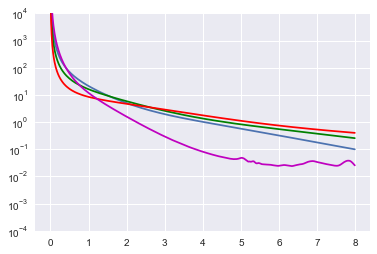

In [17]:
import pylab as plt
%matplotlib inline
plt.semilogy(red,SEDs[0,0,:]*np.power(10.0,12))
plt.semilogy(red,SEDs[0,1,:]*np.power(10.0,12),c='g')
plt.semilogy(red,SEDs[0,2,:]*np.power(10.0,12),c='r')
plt.semilogy(red,SEDs[0,3,:]*np.power(10.0,12),c='m')

plt.ylim(1E-4,1E4)

In [58]:
np.save('SED_SPIRE_PACS100', SEDs)

In [22]:
ls

SED_SPIRE_PACS100.npy
SED_prior_model.ipynb
XID+SPIRE.pkl
XID+example_run_script.ipynb
XID+posterior_analysis_validation.ipynb
test.fits
test.pkl


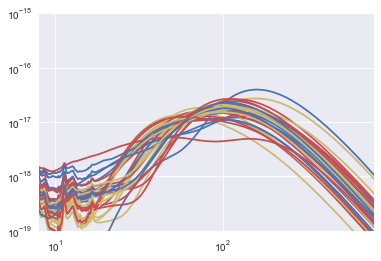

In [59]:
for i in range(0,len(temps)):
    template=ascii.read('/Users/pdh21/astrodata/SEDs/Berta2013/templates_berta_norm_LIR/'+temps[i])
    flux=template['col2']*((template['col1']/1E4)**2)/3E14
    wave=template['col1']/1E4
    plt.loglog(wave,flux)
    plt.xlim(8,800)
    plt.ylim(10E-20,10E-16)
    plt.plot([250.0,350.0,500.0, 100.0],SEDs[i,:,0])
    

In [60]:
df.to_pickle('SEDS_full.pkl')